# Ελένη Λιάρου Μηχανική Μάθηση Εργασία 31115201900100

# **Ερώτημα 1: Feedforward Neural Network**

# **Βήμα 1: Φόρτωση Δεδομένων**



In [1]:
from IPython.utils import tempdir
import numpy as np
import librosa
import torch
import librosa.display
import soundfile
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/gdrive')

path1X = '/content/gdrive/MyDrive/data/music_genre_data_di/test/mfccs/X.npy'
path2X = '/content/gdrive/MyDrive/data/music_genre_data_di/val/mfccs/X.npy'
path3X = '/content/gdrive/MyDrive/data/music_genre_data_di/train/mfccs/X.npy'
path1L = '/content/gdrive/MyDrive/data/music_genre_data_di/test/mfccs/labels.npy'
path2L = '/content/gdrive/MyDrive/data/music_genre_data_di/val/mfccs/labels.npy'
path3L = '/content/gdrive/MyDrive/data/music_genre_data_di/train/mfccs/labels.npy'

def loadSound(pathX, pathL):
  sound = []
  labels = []
  sound = np.load(pathX)
  pathL=np.load(pathL)
  #sound = tf.convert_to_tensor(sound)
  #sound = torch.from_numpy(np.array(sound))
  count = range(len(pathL))
  for tmp in count:
    if(pathL[tmp] == "hiphop"):
        l=0
        labels.append(int(l))
    elif (pathL[tmp] == "blues"):
        l=1
        labels.append(int(l))
    elif (pathL[tmp] == "classical"):
        l=2
        labels.append(int(l))
    elif (pathL[tmp] == "rock_metal_hardrock"):
        l=3
        labels.append(int(l))
  #labels = tf.convert_to_tensor(labels)
  return sound, labels




Mounted at /content/gdrive


In [2]:
  trainX , trainL = loadSound(path3X, path3L)
  testX , testL = loadSound(path1X, path1L)
  valX , valL = loadSound(path2X, path2L)

  train = list(zip(trainX, trainL))
  test = list(zip(testX, testL))
  val = list(zip(valX, valL))
  
  train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
  test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
  val_dataloader = DataLoader(val, batch_size=16, shuffle=True)

# **Βήμα 2: Ορισμός Νευρωνικού Δικτύου**

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torchvision import transforms


class NeuralNetwork(nn.Module): ## subclass of nn.Module
    def __init__(self):  ##constructor of the class
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  ## ouotputs 28*28=784)
        self.linear_relu_stack = nn.Sequential(  ## quick way to define a sequential neural network structures inside or outside an existing nn.Module
            nn.Linear(26, 128),
            nn.Linear(128, 32),  
            nn.Linear(32, 4), 
        )

    def forward(self, x): ## Defines the computation performed at every call. Should be overridden by all nn.Module subclasses.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

   

# **Bήμα 3: Ορισμός διαδικασίας εκπαίδευσης για cpu**

In [4]:

def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        X = X.type(torch.FloatTensor)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)  ## loss_fn defined above to be  nn.CrossEntropyLoss()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# **Βήμα 4 Ορισμός διαδικασίας αξιολόγησης για cpu**

In [7]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target=[]
    pred2 = []

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations. Disabling gradient calculation is useful for inference with no backpropagation
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X.float())
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            target.append(y)
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)

    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} %, macro F1 score: {f1}%,\n confusion matrix: {conf}\n")
    return f1

# **Bήμα 5: Εκπαίδευση δικτύου**

In [8]:
device = 'cpu'
model = NeuralNetwork().to(device)  ##assing model to device


# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the hyperparameters of the optimization/training process
learning_rate = 0.002
num_epochs = 30
batch_size = 16

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) ## Stochastic Gradient Descent
print(f"using cpu\n")
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


using cpu

Epoch 1
-------------------------------
loss: 1.447517  [    0/ 3200]
loss: 1.413420  [  160/ 3200]
loss: 1.371689  [  320/ 3200]
loss: 1.399081  [  480/ 3200]
loss: 1.382812  [  640/ 3200]
loss: 1.342621  [  800/ 3200]
loss: 1.376483  [  960/ 3200]
loss: 1.366276  [ 1120/ 3200]
loss: 1.369383  [ 1280/ 3200]
loss: 1.422052  [ 1440/ 3200]
loss: 1.359630  [ 1600/ 3200]
loss: 1.342886  [ 1760/ 3200]
loss: 1.373321  [ 1920/ 3200]
loss: 1.443576  [ 2080/ 3200]
loss: 1.308319  [ 2240/ 3200]
loss: 1.426842  [ 2400/ 3200]
loss: 1.384591  [ 2560/ 3200]
loss: 1.354199  [ 2720/ 3200]
loss: 1.368592  [ 2880/ 3200]
loss: 1.362488  [ 3040/ 3200]
Test Error: 
 Accuracy: 40.1%, Avg loss: 0.085030 %, macro F1 score: 0.294278434358447%,
 confusion matrix: [[ 21   0  34 301]
 [  9   0  28 287]
 [  2   0 146 149]
 [  0   0  14 385]]

Epoch 2
-------------------------------
loss: 1.353512  [    0/ 3200]
loss: 1.278136  [  160/ 3200]
loss: 1.408391  [  320/ 3200]
loss: 1.339865  [  480/ 3200]
los

# **Bήμα 6: Εκπαίδευση δικτύου με GPU**

In [26]:
from IPython.utils import tempdir
import numpy as np
import librosa
import torch
import librosa.display
import soundfile
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/gdrive')

path1X = '/content/gdrive/MyDrive/data/music_genre_data_di/test/mfccs/X.npy'
path2X = '/content/gdrive/MyDrive/data/music_genre_data_di/val/mfccs/X.npy'
path3X = '/content/gdrive/MyDrive/data/music_genre_data_di/train/mfccs/X.npy'
path1L = '/content/gdrive/MyDrive/data/music_genre_data_di/test/mfccs/labels.npy'
path2L = '/content/gdrive/MyDrive/data/music_genre_data_di/val/mfccs/labels.npy'
path3L = '/content/gdrive/MyDrive/data/music_genre_data_di/train/mfccs/labels.npy'

def loadSound(pathX, pathL):
  sound = []
  labels = []
  sound = np.load(pathX)
  pathL=np.load(pathL)
  #sound = tf.convert_to_tensor(sound)
  #sound = torch.from_numpy(np.array(sound))
  count = range(len(pathL))
  for tmp in count:
    if(pathL[tmp] == "hiphop"):
        l=0
        labels.append(int(l))
    elif (pathL[tmp] == "blues"):
        l=1
        labels.append(int(l))
    elif (pathL[tmp] == "classical"):
        l=2
        labels.append(int(l))
    elif (pathL[tmp] == "rock_metal_hardrock"):
        l=3
        labels.append(int(l))
  #labels = tf.convert_to_tensor(labels)
  return sound, labels

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torchvision import transforms


class NeuralNetwork(nn.Module): ## subclass of nn.Module
    def __init__(self):  ##constructor of the class
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  ## ouotputs 28*28=784)
        self.linear_relu_stack = nn.Sequential(  ## quick way to define a sequential neural network structures inside or outside an existing nn.Module
            nn.Linear(26, 128),
            nn.Linear(128, 32),  
            nn.Linear(32, 4), 
        )

    def forward(self, x): ## Defines the computation performed at every call. Should be overridden by all nn.Module subclasses.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

trainX , trainL = loadSound(path3X, path3L)
testX , testL = loadSound(path1X, path1L)
valX , valL = loadSound(path2X, path2L)

train = list(zip(trainX, trainL))
test = list(zip(testX, testL))
val = list(zip(valX, valL))
  
train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val, batch_size=16, shuffle=True) 

def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        X = X.type(torch.FloatTensor)
        # Compute prediction and loss
        pred = model(X.cuda())
        loss = loss_fn(pred, y)  ## loss_fn defined above to be  nn.CrossEntropyLoss()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target=[]
    pred2 = []

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations. Disabling gradient calculation is useful for inference with no backpropagation
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X.cuda().float())
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            target.append(y)
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    pred2=pred2.cpu()
    target=target.cpu()
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)

    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} %, macro F1 score: {f1}%,\n confusion matrix: {conf}\n")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NeuralNetwork().to(device)  ##assing model to device


# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the hyperparameters of the optimization/training process
learning_rate = 0.002
num_epochs = 30
batch_size = 16  

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) ## Stochastic Gradient Descent

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch 1
-------------------------------
loss: 1.596691  [    0/ 3200]
loss: 1.372581  [  160/ 3200]
loss: 1.423298  [  320/ 3200]
loss: 1.348415  [  480/ 3200]
loss: 1.419643  [  640/ 3200]
loss: 1.382809  [  800/ 3200]
loss: 1.366312  [  960/ 3200]
loss: 1.439429  [ 1120/ 3200]
loss: 1.349338  [ 1280/ 3200]
loss: 1.377662  [ 1440/ 3200]
loss: 1.389910  [ 1600/ 3200]
loss: 1.398004  [ 1760/ 3200]
loss: 1.363093  [ 1920/ 3200]
loss: 1.407809  [ 2080/ 3200]
loss: 1.334269  [ 2240/ 3200]
loss: 1.443024  [ 2400/ 3200]
loss: 1.347011  [ 2560/ 3200]
loss: 1.368717  [ 2720/ 3200]
loss: 1.285903  [ 2880/ 3200]
loss: 1.397217  [ 3040/ 3200]
Test Error: 
 Accuracy: 33.6%, Avg loss: 0.084576 %, macro F1 score: 0.19047347311442267%,
 confusion matrix: [[ 79   0   0 277]
 [ 53   0   0 271]
 [171   1   0 125]
 [ 15   0   0 384]]

Epoch 2
-------------------------------
l

# **Βήμα 7: Επιλογή Μοντέλου**

In [ ]:
device = 'cpu'
model = NeuralNetwork().to(device)  ##assing model to device


# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the hyperparameters of the optimization/training process
learning_rate = 0.002
num_epochs = 30
batch_size = 16
tmp=0
# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) ## Stochastic Gradient Descent
print(f"using cpu\n")
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    f1 = test_loop(val_dataloader, model, loss_fn)
    if f1>tmp:
      tmp=f1
    
print("Done!")


Παρατήρησα ότι το νευρωνικό δίκτυο που εκπαίδευσα είναι πιο γρήγορο όταν χρησιμοποιείται η CPU αντί για την GPU. 

# **Ερώτημα 2: Convolutional Neural Network**

# **Βήμα 1: Φόρτωση δεδομένων**

In [9]:
from IPython.utils import tempdir
import numpy as np
import librosa
import torch
import librosa.display
import soundfile
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import torchvision 
import torchvision.transforms as transforms

from google.colab import drive
drive.mount('/content/gdrive')

path1X = '/content/gdrive/MyDrive/data/music_genre_data_di/test/melgrams/X.npy'
path2X = '/content/gdrive/MyDrive/data/music_genre_data_di/val/melgrams/X.npy'
path3X = '/content/gdrive/MyDrive/data/music_genre_data_di/train/melgrams/X.npy'
path1L = '/content/gdrive/MyDrive/data/music_genre_data_di/test/melgrams/labels.npy'
path2L = '/content/gdrive/MyDrive/data/music_genre_data_di/val/melgrams/labels.npy'
path3L = '/content/gdrive/MyDrive/data/music_genre_data_di/train/melgrams/labels.npy'

def loadSound(pathX, pathL):
  sound = []
  labels = []
  sound = np.load(pathX)
  pathL=np.load(pathL)
  #sound = tf.convert_to_tensor(sound)
  #sound = torch.from_numpy(np.array(sound))
  count = range(len(pathL))
  ch=0
  cb=0
  cc=0
  cr=0
  for tmp in count:
    if(pathL[tmp] == "hiphop"):
        l=0
        ch+=1
        labels.append(int(l))
    elif (pathL[tmp] == "blues"):
        l=1
        cb+=1
        labels.append(int(l))
    elif (pathL[tmp] == "classical"):
        l=2
        cc+=1
        labels.append(int(l))
    elif (pathL[tmp] == "rock_metal_hardrock"):
        l=3
        cr+=1
        labels.append(int(l))
  #labels = tf.convert_to_tensor(labels)
  return sound, labels, ch, cb, cc, cr


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
trainX , trainL, htr, btr, ctr, rtr = loadSound(path3X, path3L)
testX , testL, hte, bte, cte, rte = loadSound(path1X, path1L)
valX , valL, hval, bval, cval, rval = loadSound(path2X, path2L)

train = list(zip(trainX, trainL))
test = list(zip(testX, testL))
val = list(zip(valX, valL))

# define the batch size for the dataloaders
batch_size = 16

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

Blues


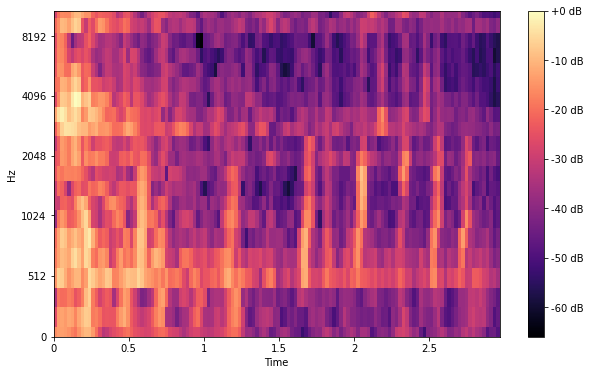

Classical


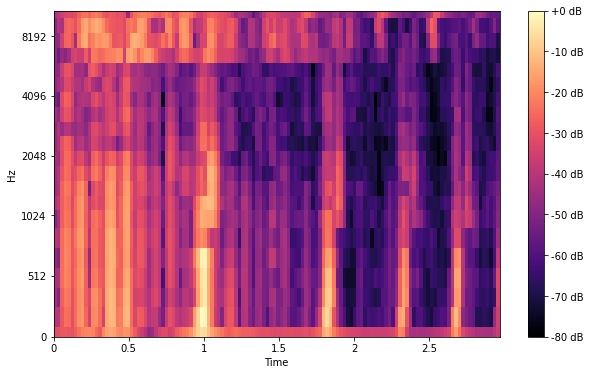

Hiphop


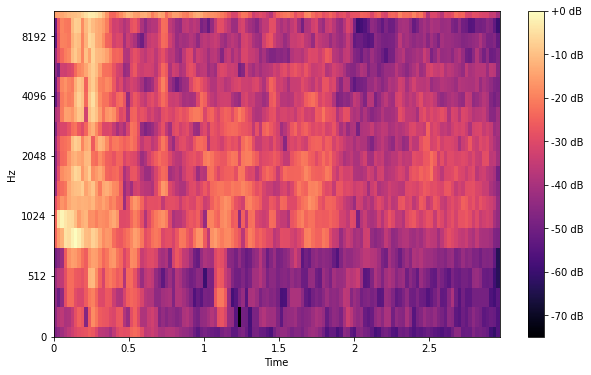

Rock metal hardrock


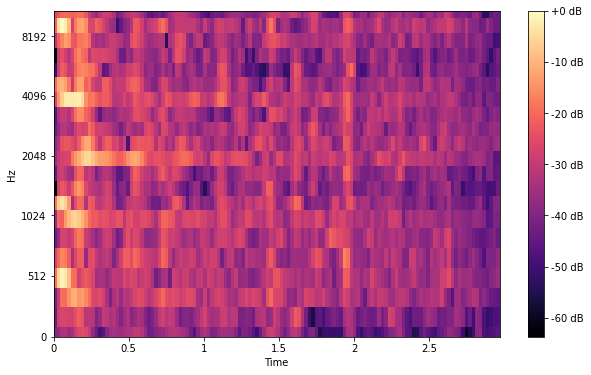

In [11]:
import librosa
import librosa.display
from IPython.display import Audio, display, Image, YouTubeVideo
import random

def visualizemelgram(data, name):
  hop_length = 512
  plt.figure(figsize=(10, 6));
  print(name)
  librosa.display.specshow(data, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2.0f dB');
  plt.show()


r = random.randint(0, 2)
if r==0:
  b = random.randint(0, btr)
  c = random.randint(0, ctr)
  h = random.randint(0, htr)
  r = random.randint(0, rtr)
  temp = np.load(path3X)
  visualizemelgram(temp[b], "Blues")
  visualizemelgram(temp[btr + c], "Classical")
  visualizemelgram(temp[btr + ctr + h], "Hiphop")
  visualizemelgram(temp[btr + ctr + htr + r], "Rock metal hardrock")
elif r==1:
  b = random.randint(0, bte)
  c = random.randint(0, cte)
  h = random.randint(0, hte)
  r = random.randint(0, rte)
  temp = np.load(path1X)
  visualizemelgram(temp[b], "Blues")
  visualizemelgram(temp[bte + c], "Classical")
  visualizemelgram(temp[bte + cte + h], "Hiphop")
  visualizemelgram(temp[bte + cte + hte + r], "Rock metal hardrock")
elif r==2:
  b = random.randint(0, bval)
  c = random.randint(0, cval)
  h = random.randint(0, hval)
  r = random.randint(0, rval)
  temp = np.load(path2X)
  visualizemelgram(temp[b], "Blues")
  visualizemelgram(temp[bval + c], "Classical")
  visualizemelgram(temp[bval + cval + h], "Hiphop")
  visualizemelgram(temp[bval + cval + hval + r], "Rock metal hardrock")


# **Βήμα 2: Ορισμός Νευρωνικού Δικτύου**

In [18]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5)  ##in out kernel
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      
      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x 


# **Βήμα 3: Εκπαίδευση δικτύου**

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 10 == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# the test loop does not need the optimizer
# we just pass the data through the trained model and measure the error in predictions
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target = []
    pred2 = []
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            target.append(y)

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    test_loss /= size
    correct /= size
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)
    tmp = 100*correct
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} %, macro F1 score: {f1}%,\n confusion matrix: {conf}\n")
    return f1, tmp

In [20]:
learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cpu'
net = LeNet().to(device)

# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, net, loss_fn, optimizer)
    test_loop(test_loader, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: ignored

Παρατηρώ ότι το μοντέλο δεν μπορεί να εκπαιδευτεί. 

# **Βήμα 4: Pooling and Padding**

In [21]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = F.max_pool2d(self.conv1(x), kernel_size=2)
      x = F.max_pool2d(self.conv2(x), kernel_size = 2)
      x = F.max_pool2d(self.conv3(x), kernel_size = 2)
      x = F.max_pool2d(self.conv4(x), kernel_size = 2)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x 


In [22]:
learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cpu'
net = LeNet().to(device)

# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, net, loss_fn, optimizer)
    test_loop(test_loader, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.394916  [    0/ 3200]
loss: 4.501748  [  160/ 3200]
loss: 2.330584  [  320/ 3200]
loss: 3.730996  [  480/ 3200]
loss: 2.239677  [  640/ 3200]
loss: 1.518948  [  800/ 3200]
loss: 1.115203  [  960/ 3200]
loss: 0.951901  [ 1120/ 3200]
loss: 1.384418  [ 1280/ 3200]
loss: 0.871652  [ 1440/ 3200]
loss: 1.078546  [ 1600/ 3200]
loss: 1.119145  [ 1760/ 3200]
loss: 1.039529  [ 1920/ 3200]
loss: 1.139102  [ 2080/ 3200]
loss: 0.985473  [ 2240/ 3200]
loss: 1.061521  [ 2400/ 3200]
loss: 0.700553  [ 2560/ 3200]
loss: 0.613124  [ 2720/ 3200]
loss: 0.818156  [ 2880/ 3200]
loss: 0.942608  [ 3040/ 3200]
Test Error: 
 Accuracy: 64.5%, Avg loss: 0.053574 %, macro F1 score: 0.6402818075814602%,
 confusion matrix: [[288  61   5   2]
 [ 80 154  36  54]
 [  2  13 276   6]
 [ 50 129  51 169]]

Epoch 2
-------------------------------
loss: 0.655993  [    0/ 3200]
loss: 0.807111  [  160/ 3200]
loss: 1.075368  [  320/ 3200]
loss: 0.842704  [  480/ 3200]
loss: 0.74221

Παρατήρησα οτι με την προσθήκη του padding και του pooling το νευρωνικό μπόρεσε να εκπαιδευτεί κατάλληλα και να πετύχει <70% ακρίβεια. Όσο το f1 αυξάνεται τόσο αυξάνεται και το accuracy

# **Βήμα 5: Αλγόριθμοι βελτιστοποίησης**

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 10 == 0:
          loss, current = loss.item(), batch * len(X)
          #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# the test loop does not need the optimizer
# we just pass the data through the trained model and measure the error in predictions
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target = []
    pred2 = []
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            target.append(y)

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    test_loss /= size
    correct /= size
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)
    tmp = 100*correct
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} %, macro F1 score: {f1}%,\n confusion matrix: {conf}\n")
    return f1, tmp


learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cpu'
net = LeNet().to(device)

# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
print("{:<20} {:<20} {:<20}".format('optimizer', 'macro f1', 'accuracy'))
for i in range(0,9):
  if i==0:
    optimizer = optim.AdamW(net.parameters(), lr = learning_rate) 
    name="AdamW"
  elif i==1:
    optimizer = optim.ASGD(net.parameters(), lr = learning_rate) 
    name="ASGD"
  elif i==2:
    optimizer = optim.Rprop(net.parameters(), lr = learning_rate) 
    name="Rprop"
  elif i==3:
    optimizer = optim.RAdam(net.parameters(), lr = learning_rate) 
    name="RAdam"
  elif i==4:
    optimizer = optim.SGD(net.parameters(), lr = learning_rate) 
    name="SGD"
  elif i==5:
    optimizer = optim.NAdam(net.parameters(), lr = learning_rate) 
    name="NAdam"
  elif i==6:
    optimizer = optim.Adagrad(net.parameters(), lr = learning_rate) 
    name="Adagrad"
  elif i==7:
    optimizer = optim.Adadelta(net.parameters(), lr = learning_rate) 
    name="Adadelta"
  elif i==8:
    optimizer = optim.RMSprop(net.parameters(), lr = learning_rate) 
    name="RMSprop"

  for t in range(num_epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      train_loop(train_loader, net, loss_fn, optimizer)
      f1, acc = test_loop(test_loader, net, loss_fn)
  #print("Done!")

  print("{:<20} {:<20} {:<20}".format(name, f1, acc))


optimizer            macro f1             accuracy            
AdamW                0.6492276956260935   63.29941860465116   
ASGD                 0.10277136258660509  25.872093023255815  
Rprop                0.10277136258660509  25.872093023255815  
RAdam                0.10277136258660509  25.872093023255815  
SGD                  0.10277136258660509  25.872093023255815  
NAdam                0.10277136258660509  25.872093023255815  
Adagrad              0.10277136258660509  25.872093023255815  
Adadelta             0.10277136258660509  25.872093023255815  
RMSprop              0.10277136258660509  25.872093023255815  


Παρακάτω υπάρχει ένα πινακάκι με τα f1 score και το accuracy κάθε optimizer που χρησιμοποίησα. 

# **Ερώτημα 3: Improving Performance**

# **Βήμα 1: Reproducibility**

In [1]:

from IPython.utils import tempdir
import numpy as np
import librosa
import torch
import librosa.display
import soundfile
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import torchvision 
import torchvision.transforms as transforms
import random

from google.colab import drive
drive.mount('/content/gdrive')

path1X = '/content/gdrive/MyDrive/data/music_genre_data_di/test/melgrams/X.npy'
path2X = '/content/gdrive/MyDrive/data/music_genre_data_di/val/melgrams/X.npy'
path3X = '/content/gdrive/MyDrive/data/music_genre_data_di/train/melgrams/X.npy'
path1L = '/content/gdrive/MyDrive/data/music_genre_data_di/test/melgrams/labels.npy'
path2L = '/content/gdrive/MyDrive/data/music_genre_data_di/val/melgrams/labels.npy'
path3L = '/content/gdrive/MyDrive/data/music_genre_data_di/train/melgrams/labels.npy'

Mounted at /content/gdrive


In [2]:
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def loadSound(pathX, pathL):
  sound = []
  labels = []
  sound = np.load(pathX)
  pathL=np.load(pathL)
  #sound = tf.convert_to_tensor(sound)
  #sound = torch.from_numpy(np.array(sound))
  count = range(len(pathL))
  ch=0
  cb=0
  cc=0
  cr=0
  for tmp in count:
    if(pathL[tmp] == "hiphop"):
        l=0
        ch+=1
        labels.append(int(l))
    elif (pathL[tmp] == "blues"):
        l=1
        cb+=1
        labels.append(int(l))
    elif (pathL[tmp] == "classical"):
        l=2
        cc+=1
        labels.append(int(l))
    elif (pathL[tmp] == "rock_metal_hardrock"):
        l=3
        cr+=1
        labels.append(int(l))
  #labels = tf.convert_to_tensor(labels)
  return sound, labels, ch, cb, cc, cr




In [3]:
trainX , trainL, htr, btr, ctr, rtr = loadSound(path3X, path3L)
testX , testL, hte, bte, cte, rte = loadSound(path1X, path1L)
valX , valL, hval, bval, cval, rval = loadSound(path2X, path2L)

train = list(zip(trainX, trainL))
test = list(zip(testX, testL))
val = list(zip(valX, valL))

# define the batch size for the dataloaders
batch_size = 16

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

In [4]:
def train_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))


# the test loop does not need the optimizer
# we just pass the data through the trained model and measure the error in predictions
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target = []
    pred2 = []
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            target.append(y)

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    test_loss /= size
    correct /= size
    pred2=pred2.cpu()
    target=target.cpu()
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)
    
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} %, macro F1 score: {f1}%,\n confusion matrix: {conf}\n")
    return f1, correct

In [5]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = F.max_pool2d(self.conv1(x), kernel_size=2)
      x = F.max_pool2d(self.conv2(x), kernel_size = 2)
      x = F.max_pool2d(self.conv3(x), kernel_size = 2)
      x = F.max_pool2d(self.conv4(x), kernel_size = 2)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x 


In [6]:
learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)

# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    test_loop(test_loader, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.4028
run number:  2
[1,  200] loss: 1.4028
Test Error: 
 Accuracy: 27.2%, Avg loss: 0.089405 %, macro F1 score: 0.21428674904943168%,
 confusion matrix: [[162 152   0  42]
 [121 165   0  38]
 [213  69   0  15]
 [ 95 257   0  47]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.4028
run number:  2
[1,  200] loss: 1.4028
Test Error: 
 Accuracy: 27.2%, Avg loss: 0.089405 %, macro F1 score: 0.21428674904943168%,
 confusion matrix: [[162 152   0  42]
 [121 165   0  38]
 [213  69   0  15]
 [ 95 257   0  47]]

Epoch 3
-------------------------------
run number:  1
[1,  200] loss: 1.4028
run number:  2
[1,  200] loss: 1.4028
Test Error: 
 Accuracy: 27.2%, Avg loss: 0.089405 %, macro F1 score: 0.21428674904943168%,
 confusion matrix: [[162 152   0  42]
 [121 165   0  38]
 [213  69   0  15]
 [ 95 257   0  47]]

Epoch 4
-------------------------------
run number:  1
[1,  200] loss: 1.4028
run number

# **Βήμα 2: Activation functions**

In [7]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x=F.relu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x=F.relu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x=F.relu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x=F.relu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.relu(x)

      x = self.dense2(x)
      x=F.relu(x)

      x = self.dense3(x)
      x=F.relu(x)

      x = self.dense4(x)
      x=F.relu(x)

      return x 

learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
print(f"Using ReLU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    f1relu, accrelu = test_loop(test_loader, net, loss_fn)
print("Done!")
  

Using ReLU
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3924
run number:  2
[1,  200] loss: 1.3924
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086643 %, macro F1 score: 0.10277136258660509%,
 confusion matrix: [[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.3924
run number:  2
[1,  200] loss: 1.3924
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086643 %, macro F1 score: 0.10277136258660509%,
 confusion matrix: [[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 3
-------------------------------
run number:  1
[1,  200] loss: 1.3924
run number:  2
[1,  200] loss: 1.3924
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086643 %, macro F1 score: 0.10277136258660509%,
 confusion matrix: [[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 4
-------------------------------
run number:  1
[1,  200] loss: 1.3924

In [9]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x=F.hardsigmoid(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x=F.hardsigmoid(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x=F.hardsigmoid(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x=F.hardsigmoid(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.hardsigmoid(x)

      x = self.dense2(x)
      x=F.hardsigmoid(x)

      x = self.dense3(x)
      x=F.hardsigmoid(x)

      x = self.dense4(x)
      x=F.hardsigmoid(x)

      return x

learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
print(f"Using Hardsigmoid")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    f1hs, acchs = test_loop(test_loader, net, loss_fn)
print("Done!")

Using Hardsigmoid
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3945
run number:  2
[1,  200] loss: 1.3945
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086580 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.3945
run number:  2
[1,  200] loss: 1.3945
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086580 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 3
-------------------------------
run number:  1
[1,  200] loss: 1.3945
run number:  2
[1,  200] loss: 1.3945
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086580 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 4
-------------------------------
run number:  1
[1,  200] loss:

In [10]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    f1elu, accelu = test_loop(test_loader, net, loss_fn)
print("Done!")
  

Using ELU
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.4037
run number:  2
[1,  200] loss: 1.4037
Test Error: 
 Accuracy: 21.6%, Avg loss: 0.087099 %, macro F1 score: 0.08876270173341302%,
 confusion matrix: [[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.4037
run number:  2
[1,  200] loss: 1.4037
Test Error: 
 Accuracy: 21.6%, Avg loss: 0.087099 %, macro F1 score: 0.08876270173341302%,
 confusion matrix: [[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 3
-------------------------------
run number:  1
[1,  200] loss: 1.4037
run number:  2
[1,  200] loss: 1.4037
Test Error: 
 Accuracy: 21.6%, Avg loss: 0.087099 %, macro F1 score: 0.08876270173341302%,
 confusion matrix: [[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 4
-------------------------------
run number:  1
[1,  200] loss: 1.4037


In [11]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.sigmoid(x)
      x = self.dense2(x)
      x=F.sigmoid(x)
      x = self.dense3(x)
      x=F.sigmoid(x)
      x = self.dense4(x)
      x=F.sigmoid(x)

      return x

learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
print(f"Using Sigmoid")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    f1s, accs = test_loop(test_loader, net, loss_fn)
print("Done!")
  

Using Sigmoid
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 3
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 4
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 5
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 6
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 7
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 8
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 9
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 10
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 11
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 12
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 13
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 14
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 15
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 16
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 17
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 18
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 19
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 20
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 21
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 22
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 23
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 24
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 25
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 26
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 27
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 28
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 29
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 30
-------------------------------
run number:  1
[1,  200] loss: 1.3982


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


run number:  2
[1,  200] loss: 1.3982
Test Error: 
 Accuracy: 23.5%, Avg loss: 0.086553 %, macro F1 score: 0.09529411764705882%,
 confusion matrix: [[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Done!


In [13]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x=F.mish(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x=F.mish(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x=F.mish(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x=F.mish(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.mish(x)
      x = self.dense2(x)
      x=F.mish(x)
      x = self.dense3(x)
      x=F.mish(x)
      x = self.dense4(x)
      x=F.mish(x)

      return x

learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
print(f"Using Mish")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    f1m, accm=test_loop(test_loader, net, loss_fn)
print("Done!")
  

Using Mish
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3958
run number:  2
[1,  200] loss: 1.3958
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086677 %, macro F1 score: 0.10277136258660509%,
 confusion matrix: [[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.3958
run number:  2
[1,  200] loss: 1.3958
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086677 %, macro F1 score: 0.10277136258660509%,
 confusion matrix: [[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 3
-------------------------------
run number:  1
[1,  200] loss: 1.3958
run number:  2
[1,  200] loss: 1.3958
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086677 %, macro F1 score: 0.10277136258660509%,
 confusion matrix: [[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 4
-------------------------------
run number:  1
[1,  200] loss: 1.3958

In [14]:

print("{:<20} {:<20} {:<20}".format('activation func', 'macro f1', 'accuracy'))
print("{:<20} {:<20} {:<20}".format('ReLU', f1relu, 100*accrelu))
print("{:<20} {:<20} {:<20}".format('Hardsigmoid', f1hs, 100*acchs))
print("{:<20} {:<20} {:<20}".format('ELU', f1elu, 100*accelu))
print("{:<20} {:<20} {:<20}".format('Sigmoid', f1s, 100*accs))
print("{:<20} {:<20} {:<20}".format('Mish', f1m, 100*accm))

activation func      macro f1             accuracy            
ReLU                 0.10277136258660509  25.872093023255815  
Hardsigmoid          0.09529411764705882  23.546511627906977  
ELU                  0.08876270173341302  21.584302325581394  
Sigmoid              0.09529411764705882  23.546511627906977  
Mish                 0.10277136258660509  25.872093023255815  


# **Βήμα 3: Learning Rate Scheduler**

In [15]:
from torch.optim import lr_scheduler

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

def train_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    f1elu, accelu = test_loop(test_loader, net, loss_fn)
print("Done!")
  

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Using ELU
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.4037


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run number:  2
[1,  200] loss: 1.4037
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Test Error: 
 Accuracy: 21.6%, Avg loss: 0.087099 %, macro F1 score: 0.08876270173341302%,
 confusion matrix: [[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.4037
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-

# **Βήμα 4:Batch Normalization**

In [17]:
from torch.optim import lr_scheduler

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 30
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

def train_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    f1elu, accelu = test_loop(test_loader, net, loss_fn)
print("Done!")
  

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Using ELU
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3794


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run number:  2
[1,  200] loss: 1.3794
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Test Error: 
 Accuracy: 22.6%, Avg loss: 0.087050 %, macro F1 score: 0.1528626132436724%,
 confusion matrix: [[193   5 158   0]
 [204   1 116   3]
 [179   1 117   0]
 [226   1 172   0]]

Epoch 2
-------------------------------
run number:  1
[1,  200] loss: 1.3794
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-0

# Βήμα 5: Regularization

Αλλαγή μόνο του weight decay

In [18]:
from torch.optim import lr_scheduler

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 60
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

def train_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
def val_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    val_loop(reproducibility=True)
    test_loop(test_loader, net, loss_fn)
print("Done!")
  


Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Using ELU
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3794


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run number:  2
[1,  200] loss: 1.3794
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
run number:  1
[1,   50] loss: 1.3635
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
run number:  2
[1,   50] loss: 1.3635
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 t

Αλλαγή μόνο του dropout στα linear layers

In [19]:
from torch.optim import lr_scheduler


class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 60
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

def train_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
def val_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    val_loop(reproducibility=True)
    test_loop(test_loader, net, loss_fn)
print("Done!")
  


Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Using ELU
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3795


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run number:  2
[1,  200] loss: 1.3795
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
run number:  1
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
run number:  2
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 t

Αλλαγή και των 2

In [20]:
from torch.optim import lr_scheduler


class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 60
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

def train_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
def val_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(reproducibility=True)
    val_loop(reproducibility=True)
    test_loop(test_loader, net, loss_fn)
print("Done!")
  


Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Using ELU
Epoch 1
-------------------------------
run number:  1
[1,  200] loss: 1.3795


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run number:  2
[1,  200] loss: 1.3795
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
run number:  1
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
run number:  2
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 t

όταν αλλάζουμε μόνο το weight decay πετυχαίνουμε απόδοση 22,6%, όταν απλά προσθέτουμε την τεχνική dropout η απόδοση γίνεται 24,5%, ενώ όταν εφαρμόσουμε και τις 2 αλλαγές έχουμε απόδοση μέχρι και 24.5%. 

# **Βήμα 6: Training efficiency**

**Batch size**

In [21]:
from torch.optim import lr_scheduler
from time import process_time

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x


learning_rate = 0.002
num_epochs = 60
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

def train_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
def val_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()




for i in range (1, 8):
  batch_size=2**i
  train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
  val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)
  t0= process_time() 
  for t in range(num_epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loop(reproducibility=True)
      val_loop(reproducibility=True)
      test_loop(test_loader, net, loss_fn)
  print("Done!")
  t1 = process_time()  - t0
  print(f"training time: {t1} \n")


Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Using ELU
Epoch 1
-------------------------------
run number:  1
[1, 1600] loss: 1.5322
[851, 1600] loss: 1.4148


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Adjusting learning rate of group 0 to 1.2352e-95.
Adjusting learning rate of group 0 to 1.2352e-95.
Adjusting learning rate of group 0 to 1.2352e-95.
Adjusting learning rate of group 0 to 1.2352e-95.
Adjusting learning rate of group 0 to 1.2352e-95.
run number:  2
[1,  100] loss: 1.3869
Adjusting learning rate of group 0 to 1.1117e-95.
Adjusting learning rate of group 0 to 1.1117e-95.
Adjusting learning rate of group 0 to 1.1117e-95.
Adjusting learning rate of group 0 to 1.1117e-95.
Adjusting learning rate of group 0 to 1.1117e-95.
run number:  1
[1,   25] loss: 1.3989
Adjusting learning rate of group 0 to 1.0005e-95.
Adjusting learning rate of group 0 to 1.0005e-95.
Adjusting learning rate of group 0 to 1.0005e-95.
Adjusting learning rate of group 0 to 1.0005e-95.
Adjusting learning rate of group 0 to 1.0005e-95.
run number:  2
[1,   25] loss: 1.3989
Adjusting learning rate of group 0 to 9.0045e-96.
Adjusting learning rate of grou

Ανάμεσα στα for loop για την εκπαίδευση και την αξιολόγηση εκτυπώνεται ο χρόνος που του πήρε για να γίνει train, ενώ σε κάθε επανάληξη του test loop εκτυπώνεται και η απόδοση. 

**Early stopping**

In [22]:
from torch.optim import lr_scheduler
import time

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)

      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 60
batch_size = 16 
device = 'cuda'
net = LeNet().to(device)
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")
# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) 

def train_loop(reproducibility=True, n_run=2, device='cuda'):

    # Early stopping
    last_loss = 100
    patience = 2
    triggertimes = 0

    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
      current_loss = val_loop(reproducibility=True)
      print('The Current Loss:', current_loss)

      if current_loss > last_loss:
          trigger_times += 1
          print('Trigger Times:', trigger_times)

          if trigger_times >= patience:
              print('Early stopping!\nStart to test process.')
              return model

      else:
          print('trigger times: 0')
          trigger_times = 0

      last_loss = current_loss
def val_loop(reproducibility=True, n_run=2, device='cuda'):
    
    for n in range(n_run):
      print('run number: ', n+1)

      # set seed before create your model  
      if reproducibility:
          torch_seed(seed=0)
      # compile model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:   
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
      return loss




for i in range (1, 8):
  batch_size=2**i
  train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
  val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)
  t0= process_time()
  for t in range(num_epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loop(reproducibility=True)
      test_loop(test_loader, net, loss_fn)
  print("Done!")
  t1 = process_time() - t0
  print(f"training time: {t1}% \n")
    


Adjusting learning rate of group 0 to 2.6819e-138.
Adjusting learning rate of group 0 to 2.6819e-138.
Adjusting learning rate of group 0 to 8.9397e-139.
Adjusting learning rate of group 0 to 8.9397e-139.
Adjusting learning rate of group 0 to 2.9799e-139.
Using ELU
Epoch 1
-------------------------------
run number:  1
[1, 1600] loss: 1.5322
[851, 1600] loss: 1.4148


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Adjusting learning rate of group 0 to 6.2230e-234.
Adjusting learning rate of group 0 to 6.2230e-234.
Adjusting learning rate of group 0 to 6.2230e-234.
Adjusting learning rate of group 0 to 6.2230e-234.
Adjusting learning rate of group 0 to 6.2230e-234.
The Current Loss: tensor(1.3918, device='cuda:0', grad_fn=<NllLossBackward0>)
trigger times: 0
run number:  2
[1,  100] loss: 1.3869
Adjusting learning rate of group 0 to 5.6007e-234.
Adjusting learning rate of group 0 to 5.6007e-234.
Adjusting learning rate of group 0 to 5.6007e-234.
Adjusting learning rate of group 0 to 5.6007e-234.
Adjusting learning rate of group 0 to 5.6007e-234.
run number:  1
[1,   25] loss: 1.3989
Adjusting learning rate of group 0 to 5.0407e-234.
Adjusting learning rate of group 0 to 5.0407e-234.
Adjusting learning rate of group 0 to 5.0407e-234.
Adjusting learning rate of group 0 to 5.0407e-234.
Adjusting learning rate of group 0 to 5.0407e-234.
The Curre

Όσο αυξάνεται το batch size τόσο πιο γρήγορα επιτυγχάνεται η εκπαίδευση του μοντέλου. 